### Research: how well the photodiode signal correlates with Ed values (interpolated to the Lu response time).

#### Terminology:

**Ed (Downwelling Irradiance)** represents the incoming radiant flux (radiant power) from all directions of the upper hemisphere onto a surface (e.g., the Earth's surface or an object). It includes all the incoming electromagnetic radiation, regardless of the direction. It characterizes the total radiant energy received by a surface.

**Lu (Upwelling Radiance)** characterizes the radiant energy that is reflected or emitted by the surface and travels upward.

**Ld (Downwelling Radiance).** Is a measure of the brightness of the radiation coming from the upper hemisphere towards a specific point on the surface. It provides information about the intensity and directionality of the incoming radiation.

Ed represents the incoming energy,
Ld represents the incoming energy's intensity and directionality, and
Lu represents the outgoing energy from the surface or object.

**Photodiodes** are often used to measure the intensity of light in lux. When light falls on a photodiode, it generates an electrical signal, the strength of which is proportional to the illuminance (lux) of the incident light.

**Photodiode Signal and Reflectance Spectrum.** A light source illuminates a material, and the photodiode measures the intensity of the reflected light at various wavelengths. The resulting photodiode signal is used to create a reflectance spectrum, which provides information about how the material reflects light across the visual spectrum. With the photodiode signal in lux and the photopic data, which typically includes the photopic luminous efficiency function V(λ) as a function of wavelength (λ), we can "weighting" the illuminance measurement to account for the human eye's sensitivity to different wavelengths. This calculation provides a way to convert the measured illuminance into a quantity that represents the perceived brightness of light at that specific wavelength. The result is known as "luminance" or "brightness" at that particular wavelength.

**Hypstar water transfer protocol.** 
Ed - Downwelling Irradiance; Ld - Downwelling Radiance; Lu - Upwelling Radiance
Transfer protocol: [Ed 3x] - [Ld 3x] - [Lu 6x] - [Ld 3x] - [Ed 3x]. Sequential measurements.

![](../data/photodiode/_img/chart2.jpg)

![](https://github.com/fjodorsevtsenko/rs-pr-water/blob/main/img/chart2.png)
<img src = '../../../../img/chart2.png' width=100%>

![](../data/photodiode/_img/chart.jpg)

<img src = '../../../../img/chart.png' width=100%>

#### Data available

**photopic.dat**: wavelength;V(lambda)
**monitorpd**: photodiode time series (lux of photometric units)
**L1A;L1B;L1C**
HYPERNETS_W_LVES_L1A_IRR: downwelling irradiance (Ed all six measurements)
HYPERNETS_W_LVES_L1B_IRR: downwelling irradiance (Ed0 and Ed1 averages)
HYPERNETS_W_LVES_L1C_ALL: downwelling irradiance; downwelling radiance; upwelling radiance

#### Task, simplified
<br>

1. Get photodiode signal.
2. Get and transform photopic data.
3. Get Ed0 (start) and Ed1 (end) from L1B.
4. Calculate Ed0-Luminance ratio and Ed1-Luminance ratio.
5. Adjust Ed0-Luminance ratio and Ed1-Luminance ratio to the same UTC.
6. Calculate Pearson correlation between Ed0-Luminance ratio and Ed1-Luminance ratio.
7. Plot the relationship.

### Table of content

**[01]: Data preprocessing**

- [01-01]: Use the next terminal commands to copy 'monitorPD' and 'hypernets' data files into relevant folders
- [01-02]: Import libraries and set path-variables to files' locations
- [01-03]: Run extraction/transformation for 'photopic' data
- [01-04]: Run extraction/transformation for 'monitorpd' data; Save result in a 'parquet' format
- [01-05]: Read 'monitorpd' dataset from 'parquet' file
- [01-06]: Run extraction/transformation for 'hypernets' data- Ed0 and Ed1; Save result in a 'parquet' format
- [01-07]: Read 'hypernets' dataset from 'parquet' file

**[02]: Find intersection space between 'photopic', 'monitorpd' and 'hypernets' datasets by 'wavelength' and 'utc'**
- [02-01]: Get common by 'wavelength' and 'utc'
- [02-02]: Adjust 'monitorpd' dataset by common 'utc'
- [02-03]: Adjust 'hypernets' dataset by common 'wavelength' and 'utc'
- [02-04]: Save 'index-utc' combination
- [02-05]: Get Ed0 ratio
- [02-06]: Get Ed1 ratio
- [02-07]: Adjust Ed0 and Ed1 to common shape

**[03]: Calculate correlation between Ed0 and Ed1 ratios**

**[04]: Plot the relationship between Ed0 and Ed1 ratios**


<br>
<hr>

#### [01]: Data preprocessing

##### [01-01]: Use the next terminal commands to copy 'monitorPD' and 'hypernets' data files into relevant folders

In [1]:
# _nc_files_HYPERNETS_W_LVES_L1B_IRR % find ../LVES -type f -name "HYPERNETS_W_LVES_L1B_IRR_*.nc" -exec cp {} . \;
# find ../DATA -type f -name "monitorPD.csv" -exec sh -c 'new_name="./$(basename "$(dirname "$0")").csv"; cp "$0" "$new_name"' {} \;

##### [01-02]: Import libraries and set path-variables to files' locations

In [2]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
from models.helpers import _ltt000027_fsevts_02_photodiode_correlation as _ltt000027

PATH_TO_DATA = "../data/photodiode/"
PATH_TO_EXPORT = "../data/photodiode/_export/"
PATH_TO_PHOTOPIC = f"{PATH_TO_DATA}photopic.dat"
PATH_TO_HYPERNETS_NC = f"{PATH_TO_DATA}_nc_HYPERNETS_W_LVES_L1B_IRR/"
PATH_TO_MONITORPD_CSV = f"{PATH_TO_DATA}_csv_MONITORPD/"

helper = _ltt000027.Helper()

##### [01-03]: Run extraction/transformation for 'photopic' data

In [3]:
df_photopic = helper.read_photopic(PATH_TO_PHOTOPIC)
df_photopic_transformed = helper.transform_photopic(df_photopic)
df_photopic_transformed

,index,380,385,390,395,400,405,410,415,420,...,735,740,745,750,755,760,765,770,775,780
0,v_lambda_,0.0002,0.000396,0.0008,0.00155,0.0028,0.00466,0.0074,0.0118,0.0175,...,0.000361,0.000249,0.000172,0.00012,0.000085,0.00006,0.000042,0.00003,0.000021,0.000015


##### [01-04]: Run extraction/transformation for 'monitorpd' data; Save result in a 'parquet' format

In [4]:
df_monitorpd_transformed = pd.concat(
    map(lambda df_: helper.transform_monitorpd(df_), 
        map(helper.read_monitorpd, helper.get_list_of_files(PATH_TO_MONITORPD_CSV))
), ignore_index=True)
df_monitorpd_transformed = df_monitorpd_transformed.sort_values(by='utc_', ascending=True)
df_monitorpd_transformed.to_parquet(f"{PATH_TO_EXPORT}_02_df_monitorpd_transformed.parquet", index=False)

##### [01-05]: Read 'monitorpd' dataset from 'parquet' file

In [5]:
df_monitorpd_transformed = pd.read_parquet(f"{PATH_TO_EXPORT}_02_df_monitorpd_transformed.parquet")
df_monitorpd_transformed.head(3)

,utc_,lx_,lx_inv_
0,1689915635,20159.0,0.00005
1,1689915636,20140.8,0.00005
2,1689915638,20141.6,0.00005


##### [01-06]: Run extraction/transformation for 'hypernets' data- Ed0 and Ed1; Save result in a 'parquet' format

In [6]:
# Ed beginning phase
df_nc_transform_0 = pd.concat(
    map(helper.get_nc_transformed_0, helper.get_list_of_files(PATH_TO_HYPERNETS_NC)
), ignore_index=True)

df_nc_transform_0 = df_nc_transform_0.sort_values(by='utc_', ascending=True)
df_nc_transform_0.to_parquet(f"{PATH_TO_EXPORT}_02_df_nc_transformed_0.parquet", index=False)

In [7]:
# Ed ending phase
df_nc_transform_1 = pd.concat(
    map(helper.get_nc_transformed_1, helper.get_list_of_files(PATH_TO_HYPERNETS_NC)
), ignore_index=True)

df_nc_transform_1 = df_nc_transform_1.sort_values(by='utc_', ascending=True)
df_nc_transform_1.to_parquet(f"{PATH_TO_EXPORT}_02_df_nc_transformed_1.parquet", index=False)

##### [01-07]: Read 'hypernets' dataset from 'parquet' file

In [8]:
df_nc_transform_0 = pd.read_parquet(f"{PATH_TO_EXPORT}_02_df_nc_transformed_0.parquet")
df_nc_transform_0.head(3)

,utc_,350,351,352,353,354,355,356,357,358,...,1091,1092,1093,1094,1095,1096,1097,1098,1099,1100
0,1689915676,139.896606,145.060913,149.192886,152.974747,164.423500,163.010925,156.661385,145.117345,138.356697,...,149.501770,154.458481,146.774132,140.697375,128.467457,123.450153,130.477936,124.133533,121.280273,148.973389
1,1689916575,161.907890,168.990608,170.145760,176.260399,187.366058,188.746529,180.372185,166.402359,157.716202,...,169.179604,174.959175,174.539085,156.256490,178.930298,164.121323,153.947281,146.457596,143.814651,141.991196
2,1689917475,177.386772,181.828560,185.042961,189.548058,203.414146,205.429596,195.282272,176.238749,169.310211,...,189.879265,177.713013,173.848686,162.848836,155.844643,170.411537,152.039856,161.167267,165.148636,154.165115


In [9]:
df_nc_transform_1 = pd.read_parquet(f"{PATH_TO_EXPORT}_02_df_nc_transformed_1.parquet")
df_nc_transform_1.head(3)

,utc_,350,351,352,353,354,355,356,357,358,...,1091,1092,1093,1094,1095,1096,1097,1098,1099,1100
0,1689915754,142.550522,147.574211,150.712372,154.669807,164.871346,166.075813,158.392525,144.982076,137.421059,...,151.593727,156.967537,140.197639,141.519674,145.308426,145.080521,143.925034,143.351284,125.748226,136.977936
1,1689916652,163.663124,168.368553,171.821381,175.707245,187.733711,190.072006,180.430077,165.348012,156.123352,...,188.054024,173.735954,182.840248,163.104975,164.546234,173.787094,162.730103,169.695465,144.259354,165.980408
2,1689917550,177.708466,183.056145,186.081207,191.546562,205.449745,203.993362,196.628700,179.525533,170.985229,...,205.970612,187.659409,175.906380,181.345225,175.194138,176.251663,167.392502,168.803024,155.513329,156.134140


#### [02]: Find intersection space between 'photopic', 'monitorpd' and 'hypernets' datasets by 'wavelength' and 'utc'

##### [02-01]: Get common by 'wavelength' and 'utc'

In [10]:
common_numeric_columns = (df_photopic_transformed.columns).intersection(df_nc_transform_0.columns)
common_columns = {'utc_'}.union(common_numeric_columns)
print(f"Common wavelength_: {len(common_numeric_columns)}")
print(f"Common columns: {len(common_columns)}")
common_utc_0 = set(df_monitorpd_transformed['utc_']).intersection(set(df_nc_transform_0['utc_']))
common_utc_1 = set(df_monitorpd_transformed['utc_']).intersection(set(df_nc_transform_1['utc_']))
print(f"Common utc_ 0: {len(common_utc_0)}")
print(f"Common utc_ 1: {len(common_utc_1)}")
common_utc = common_utc_0 | common_utc_1
print(f"Common utc_: {len(common_utc)}")

Common wavelength_: 81
Common columns: 82
Common utc_ 0: 1757
Common utc_ 1: 1746
Common utc_: 3503


##### [02-02]: Adjust 'monitorpd' dataset by common 'utc'

In [11]:
df_monitorpd_transformed_same_shape_0 = df_monitorpd_transformed[df_monitorpd_transformed['utc_'].isin(list(common_utc_0))].reset_index()
df_monitorpd_transformed_same_shape_0 = df_monitorpd_transformed_same_shape_0.drop('index', axis=1)
df_monitorpd_transformed_same_shape_0.shape

(1757, 3)

In [12]:
df_monitorpd_transformed_same_shape_1 = df_monitorpd_transformed[df_monitorpd_transformed['utc_'].isin(list(common_utc_1))].reset_index()
df_monitorpd_transformed_same_shape_1 = df_monitorpd_transformed_same_shape_1.drop('index', axis=1)
df_monitorpd_transformed_same_shape_1.shape

(1746, 3)

##### [02-03]: Adjust 'hypernets' dataset by common 'wavelength' and 'utc'

In [13]:
df_nc_transform_same_shape_0 = df_nc_transform_0[list(common_columns)]
df_nc_transform_same_shape_0 = df_nc_transform_same_shape_0[df_nc_transform_same_shape_0['utc_'].isin(list(common_utc))]
df_nc_transform_same_shape_0 = df_nc_transform_same_shape_0
df_nc_transform_same_shape_0.shape

(1757, 82)

In [14]:
df_nc_transform_same_shape_1 = df_nc_transform_1[list(common_columns)]
df_nc_transform_same_shape_1 = df_nc_transform_same_shape_1[df_nc_transform_same_shape_1['utc_'].isin(list(common_utc))]
df_nc_transform_same_shape_1 = df_nc_transform_same_shape_1
df_nc_transform_same_shape_1.shape

(1746, 82)

##### [02-04]: Save 'index-utc' combination

In [15]:
df_nc_index_utc_0 = df_nc_transform_same_shape_0[['utc_']].copy()
df_nc_index_utc_0['index_'] = df_nc_index_utc_0.index
df_nc_index_utc_0.set_index('utc_')
df_nc_index_utc_0.shape

(1757, 2)

In [16]:
df_nc_index_utc_1 = df_nc_transform_same_shape_1[['utc_']].copy()
df_nc_index_utc_1['index_'] = df_nc_index_utc_1.index
df_nc_index_utc_1.set_index('utc_')
df_nc_index_utc_1.shape

(1746, 2)

##### [02-05]: Get Ed0 ratio

In [17]:
result = df_photopic_transformed[common_numeric_columns].values * df_nc_transform_same_shape_0[common_numeric_columns].values
df_result = pd.DataFrame(result, columns=common_numeric_columns)
df_result['utc_'] = df_nc_transform_same_shape_0['utc_']
df_result['lx_'] = df_result[common_numeric_columns].sum(axis=1)
Ed_0 = df_result.drop(columns=common_numeric_columns)
Ed_0 = df_nc_index_utc_0.merge(Ed_0, on='utc_', how='left')
Ed_0 = Ed_0.merge(df_monitorpd_transformed, on='utc_', how='left')
Ed_0['ratio_'] = Ed_0['lx__x'] / Ed_0['lx__y']
Ed_0.head(3)

,utc_,index_,lx__x,lx__y,lx_inv_,ratio_
0,1689915676,0,10288.083922,20098.5,0.000050,0.511883
1,1689916575,1,12160.575194,25260.2,0.000040,0.481412
2,1689917475,2,12661.611588,26873.7,0.000037,0.471153


##### [02-06]: Get Ed1 ratio

In [18]:
result = df_photopic_transformed[common_numeric_columns].values * df_nc_transform_same_shape_1[common_numeric_columns].values
df_result = pd.DataFrame(result, columns=common_numeric_columns)
df_result['utc_'] = df_nc_transform_same_shape_1['utc_']
df_result['lx_'] = df_result[common_numeric_columns].sum(axis=1)
Ed_1 = df_result.drop(columns=common_numeric_columns)
Ed_1 = df_nc_index_utc_1.merge(Ed_1, on='utc_', how='left')
Ed_1 = Ed_1.merge(df_monitorpd_transformed, on='utc_', how='left')
Ed_1['ratio_'] = Ed_1['lx__x'] / Ed_1['lx__y']
Ed_1.head(3)

,utc_,index_,lx__x,lx__y,lx_inv_,ratio_
0,1689915754,0,10340.337894,20698.5,0.000048,0.499569
1,1689916652,1,12164.250095,25301.7,0.000040,0.480768
2,1689917550,2,12693.590911,28441.6,0.000035,0.446304


##### [02-07]: Adjust Ed0 and Ed1 to common shape

In [19]:
common_index = set(Ed_0['index_']).intersection(set(Ed_1['index_']))
print(f"Common index_: {len(common_index)}")

Common index_: 1730


In [20]:
Ed0_same_shape = Ed_0[Ed_0['index_'].isin(list(common_index))].set_index('index_')
Ed0_same_shape.shape

(1730, 5)

In [21]:
Ed1_same_shape = Ed_1[Ed_1['index_'].isin(list(common_index))].set_index('index_')
Ed1_same_shape.shape

(1730, 5)

#### [03]: Calculate correlation between Ed0 and Ed1 ratios

In [22]:
# Calculate the Pearson correlation between Set1 and Set2 features
correlation = Ed0_same_shape['ratio_'].corr(Ed1_same_shape['ratio_'], method='pearson')
print(f"Correlation between Ed0_ratio and Ed1_ratio: {correlation}")

Correlation between Ed0_ratio and Ed1_ratio: 0.6375715715784863


#### [04]: Plot the relationship between Ed0 and Ed1 ratios

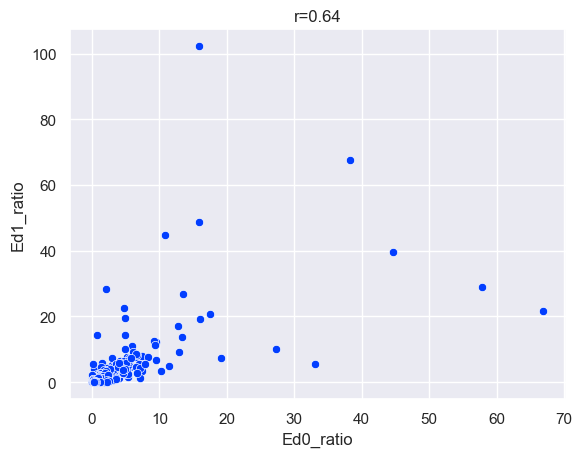

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Set the Seaborn theme
sns.set_theme(style="darkgrid", palette="bright")

sns.scatterplot(x=Ed0_same_shape['ratio_'], y=Ed1_same_shape['ratio_'])
plt.title(f"r={round(correlation,2)}")
plt.xlabel('Ed0_ratio')
plt.ylabel('Ed1_ratio')

plt.show()